In [7]:
#Import scikit-learn dataset library
import scipy.io as sio
import pandas as pd
import numpy as np
from tqdm import tnrange, tqdm_notebook
from sklearn.preprocessing import maxabs_scale, minmax_scale
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pylab as plt
import seaborn as sns
import yaml
import csv
import itertools
import time, warnings\


warnings.filterwarnings('ignore')
sns.set(style='whitegrid',palette='cividis')

In [8]:
# No V0
rdata = sio.loadmat('Data_noV0/rData.mat')['rData_all'].T
cdata = sio.loadmat('Data_noV0/cData.mat')['cData_all'].T
xdata = sio.loadmat('Data_noV0/xData.mat')['xData_all'].T
pdata = sio.loadmat('Data_noV0/pData.mat')['pData_all'].T

In [9]:
# Labels No V0
pos = sio.loadmat('Data_noV0/posPANSS.mat')['pos_all'].T
neg = sio.loadmat('Data_noV0/negPANSS.mat')['neg_all'].T
gen = sio.loadmat('Data_noV0/genPANSS.mat')['gen_all'].T
tot = sio.loadmat('Data_noV0/totPANSS.mat')['tot_all'].T
cog = sio.loadmat('Data_noV0/cogPANSS.mat')['PANSS_cog_all'].T

In [10]:
# Normalization
rdata_maxabs = maxabs_scale(rdata,axis=0)
cdata_maxabs = maxabs_scale(cdata,axis=0)
pdata_maxabs = maxabs_scale(pdata,axis=0)
xdata_maxabs = maxabs_scale(xdata,axis=0)
data_maxabs = [rdata_maxabs,cdata_maxabs,pdata_maxabs,xdata_maxabs]

In [11]:
# score normalization
cog_app = np.vstack((cog,[10],[52]))
# score = np.hstack((pos,neg,gen,tot))
cog_minmax = minmax_scale(cog_app,axis=0)
cog_maxabs = maxabs_scale(cog_app,axis=0)
cog_norm = cog_minmax[:-2]
# cog_norm = cog_maxabs[:-2]

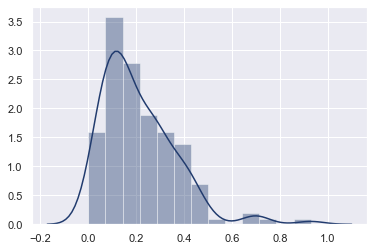

In [12]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(cog_norm)

In [13]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LassoLars, LassoLarsIC 
from sklearn.linear_model import OrthogonalMatchingPursuit, ElasticNet

In [14]:
def cal_score(data,data_max,data_min):
    return np.dot(data,(data_max - data_min)) + data_min

In [15]:
def create_alpha(ll,ul,step):
    ilist=[]
    ilist_exp = np.linspace(ll,ul,step)
    ilist_raw = [[10**(item),5.0*10**(item)] for item in ilist_exp]
    [ilist.extend(i) for i in ilist_raw]
    return ilist

In [16]:
def to_sets(rf_cv):
    rf_params_list =[]
    cnt_loop = []
    for value in rf_cv.values():
        cnt_loop.append(len(value))
    keys = list(rf_cv.keys())

    
    for a in range(cnt_loop[0]):
        for b in range(cnt_loop[1]):
            for c in range(cnt_loop[2]):
                for d in range(cnt_loop[3]):
                    for e in range(cnt_loop[4]):
                        for f in range(cnt_loop[5]):
                            tmp=[rf_cv[keys[0]][a], rf_cv[keys[1]][b], rf_cv[keys[2]][c],
                                 rf_cv[keys[3]][d], rf_cv[keys[4]][e], rf_cv[keys[5]][f]]
                            rf_params_list.append(tmp)
    return rf_params_list
    

## LassoCD

In [11]:
def lassoCD(X, y, ll, ul, step, state, score_min, score_max, rf_params):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    feature = []
    score = []
    metric = []
    m_mse = []
    m_r2 = []
#     ilist = create_alpha(ll,ul,step)
    ilist = np.linspace(ll,ul,step)
    pbar = tnrange(step*10, desc='loop')
    for i in ilist: # search best parameter
        mse = []
        r2 = []
        fea = []
        sco_pred = []
        sco_true = []
        for train_index, test_index in kf.split(X):
            y_train, y_test_raw = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            
            clf = Lasso(alpha=i)
            clf.fit(X_train_tmp, np.ravel(y_train))
            fea_idx = [i for i,x in enumerate(clf.coef_) if x>0]
            X_train = X_train_tmp[:,fea_idx]
            X_test = X_test_tmp[:,fea_idx]
            y_test_raw = list(list(zip(*y_test_raw))[0])

            rRF = RandomForestRegressor(n_estimators=rf_params[0], 
                                        criterion=rf_params[1], 
                                        max_depth = rf_params[2], 
                                        min_samples_leaf = rf_params[3], 
                                        min_samples_split = rf_params[4], 
                                        max_features=rf_params[5], 
                                        random_state=state)
            
            rRF.fit(X_train, np.ravel(y_train))
            y_test_pred_raw = rRF.predict(X_test)
            y_test_pred = cal_score(y_test_pred_raw,score_max,score_min)
            y_test = cal_score(y_test_raw,score_max,score_min)
            mse.append(mean_squared_error(y_test, y_test_pred))
            r2.append(r2_score(y_test, y_test_pred))
            fea.append(fea_idx)
            sco_pred.append(list(y_test_pred))
            sco_true.append(list(y_test))
            pbar.update(1)
        feature.append(fea)
        score.append((sco_pred, sco_true))
        metric.append((mse,r2))
        m_mse.append(sum(mse)/10)  # mean mse trace for all alpha
        m_r2.append(sum(r2)/10)    # mean r2 trace for all alpha
    
    a = m_r2.index(max(m_r2))
    feature_fd = [len(feature[a][i]) for i in range(10)]
    num_feature = int(np.mean(feature_fd))
    df = {'max_r2': m_r2[a], 'best_alpha': ilist[a], 'num_features': num_feature}
    pbar.close()
#     plt.figure()
#     plt.plot(ilist,m_r2)
#     plt.xlabel('$alpha$')
#     plt.ylabel('$R^2$')
    print('best r2_score=',m_r2[a],', corresponding alpha=', ilist[a])
    print('number of selected features:',num_feature)
    return df, feature[a], score[a], metric[a]

In [12]:
def train_lassoCD(X, y, cfg):
    ## set configs    
    result = []
    ll = cfg.get("ll")
    ul = cfg.get("ul")
    step = cfg.get("step")
    state = cfg.get("random_state")
    score_min = cfg.get("score_min")
    score_max = cfg.get("score_max")
    rf_cv = cfg.get("rf_params_set")
    rf_params_list = to_sets(rf_cv)
    for rf_params in rf_params_list:
        result_row, feature, score, metric = lassoCD(X, y, ll, ul, step, state, score_min, score_max, rf_params)
        result_row.update({"params":rf_params})
        result.append(result_row)
        print(result_row)
    return result, feature, score, metric

### cdata

In [16]:
X = cdata_maxabs
y = cog_norm
yamlfile = 'config/lassoCD_rf_cdata.yaml'
with open(yamlfile, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [36]:
write_keys = ['max_r2','best_alpha','num_features','params']
save_result_path = cfg.get("save_result_path")
# save_result_path = "./results/LassoCD_rf_cdata_nonorm.csv"
result, feature, score, metric = train_lassoCD(X,y,cfg)


best r2_score= -0.0743579134366448 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.0743579134366448, 'best_alpha': 0.0066, 'num_features': 4, 'params': [100, 'mse', 2, 1, 2, 'sqrt']}



best r2_score= -0.07473872013695029 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.07473872013695029, 'best_alpha': 0.0066, 'num_features': 4, 'params': [100, 'mse', 2, 1, 2, 'auto']}



best r2_score= -0.10783437765327789 , corresponding alpha= 0.006699999999999999
number of selected features: 4
{'max_r2': -0.10783437765327789, 'best_alpha': 0.006699999999999999, 'num_features': 4, 'params': [100, 'mse', 2, 3, 2, 'sqrt']}



best r2_score= -0.12403251850583599 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.12403251850583599, 'best_alpha': 0.0066, 'num_features': 4, 'params': [100, 'mse', 2, 3, 2, 'auto']}



best r2_score= -0.0857466840345198 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.0857466840345198, 'best_alpha': 0.0066, 'num_features': 4, 'params': [100, 'mse', 3, 1, 2, 'sqrt']}



best r2_score= -0.08496338880332485 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.08496338880332485, 'best_alpha': 0.0066, 'num_features': 4, 'params': [100, 'mse', 3, 1, 2, 'auto']}



best r2_score= -0.12274776375884403 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.12274776375884403, 'best_alpha': 0.0066, 'num_features': 4, 'params': [100, 'mse', 3, 3, 2, 'sqrt']}



best r2_score= -0.12917322642171117 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.12917322642171117, 'best_alpha': 0.0066, 'num_features': 4, 'params': [100, 'mse', 3, 3, 2, 'auto']}



best r2_score= -0.11908079443643182 , corresponding alpha= 0.0065
number of selected features: 5
{'max_r2': -0.11908079443643182, 'best_alpha': 0.0065, 'num_features': 5, 'params': [100, 'mse', 5, 1, 2, 'sqrt']}



best r2_score= -0.11361542132682186 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.11361542132682186, 'best_alpha': 0.0066, 'num_features': 4, 'params': [100, 'mse', 5, 1, 2, 'auto']}



best r2_score= -0.1271355770903189 , corresponding alpha= 0.0031000000000000003
number of selected features: 23
{'max_r2': -0.1271355770903189, 'best_alpha': 0.0031000000000000003, 'num_features': 23, 'params': [100, 'mse', 5, 3, 2, 'sqrt']}



best r2_score= -0.15557475363776743 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.15557475363776743, 'best_alpha': 0.0066, 'num_features': 4, 'params': [100, 'mse', 5, 3, 2, 'auto']}



best r2_score= -0.0726525292292998 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.0726525292292998, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 2, 1, 2, 'sqrt']}



best r2_score= -0.07541491929578868 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.07541491929578868, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 2, 1, 2, 'auto']}



best r2_score= -0.10392668171875226 , corresponding alpha= 0.006699999999999999
number of selected features: 4
{'max_r2': -0.10392668171875226, 'best_alpha': 0.006699999999999999, 'num_features': 4, 'params': [150, 'mse', 2, 3, 2, 'sqrt']}



best r2_score= -0.133666392543481 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.133666392543481, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 2, 3, 2, 'auto']}



best r2_score= -0.07736290310071589 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.07736290310071589, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 3, 1, 2, 'sqrt']}



best r2_score= -0.09124431275137605 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.09124431275137605, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 3, 1, 2, 'auto']}



best r2_score= -0.11598215431788275 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.11598215431788275, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 3, 3, 2, 'sqrt']}



best r2_score= -0.14670992944969158 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.14670992944969158, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 3, 3, 2, 'auto']}



best r2_score= -0.10809157878572599 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.10809157878572599, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 5, 1, 2, 'sqrt']}



best r2_score= -0.12460145039005825 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.12460145039005825, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 5, 1, 2, 'auto']}



best r2_score= -0.13927196792528343 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.13927196792528343, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 5, 3, 2, 'sqrt']}



best r2_score= -0.1759318989689411 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.1759318989689411, 'best_alpha': 0.0066, 'num_features': 4, 'params': [150, 'mse', 5, 3, 2, 'auto']}



best r2_score= -0.07773481775082547 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.07773481775082547, 'best_alpha': 0.0066, 'num_features': 4, 'params': [200, 'mse', 2, 1, 2, 'sqrt']}



best r2_score= -0.08266379204887465 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.08266379204887465, 'best_alpha': 0.0066, 'num_features': 4, 'params': [200, 'mse', 2, 1, 2, 'auto']}



best r2_score= -0.1072232163056183 , corresponding alpha= 0.006699999999999999
number of selected features: 4
{'max_r2': -0.1072232163056183, 'best_alpha': 0.006699999999999999, 'num_features': 4, 'params': [200, 'mse', 2, 3, 2, 'sqrt']}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




best r2_score= -0.08768345640809698 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.08768345640809698, 'best_alpha': 0.0066, 'num_features': 4, 'params': [200, 'mse', 3, 1, 2, 'sqrt']}



best r2_score= -0.09520215025701631 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.09520215025701631, 'best_alpha': 0.0066, 'num_features': 4, 'params': [200, 'mse', 3, 1, 2, 'auto']}


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




best r2_score= -0.12138176725830037 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.12138176725830037, 'best_alpha': 0.0066, 'num_features': 4, 'params': [200, 'mse', 5, 1, 2, 'sqrt']}



best r2_score= -0.13043426279027032 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.13043426279027032, 'best_alpha': 0.0066, 'num_features': 4, 'params': [200, 'mse', 5, 1, 2, 'auto']}



best r2_score= -0.14743946274117362 , corresponding alpha= 0.0029
number of selected features: 24
{'max_r2': -0.14743946274117362, 'best_alpha': 0.0029, 'num_features': 24, 'params': [200, 'mse', 5, 3, 2, 'sqrt']}



best r2_score= -0.18186322346795755 , corresponding alpha= 0.0066
number of selected features: 4
{'max_r2': -0.18186322346795755, 'best_alpha': 0.0066, 'num_features': 4, 'params': [200, 'mse', 5, 3, 2, 'auto']}


In [440]:
#record the rows in csv
with open(save_result_path,'w') as csv_file:
    # write header and rows to csv file
    csv_writer = csv.DictWriter(csv_file, write_keys)
    csv_writer.writeheader()
    csv_writer.writerows(result)

In [442]:
from tkinter import _flatten
pred = list(_flatten(score[0]))
true = list(_flatten(score[1]))
df_score = pd.DataFrame({'Predict':pred,'True':true})
df_score.corr()

,Predict,True
Predict,1.000000,0.170514
True,0.170514,1.000000


### pdata

In [13]:
X = pdata_maxabs
y = cog_norm
yamlfile = 'config/lassoCD_rf_pdata.yaml'
with open(yamlfile, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [18]:
write_keys = ['max_r2','best_alpha','num_features','params']
save_result_path = cfg.get("save_result_path")
result, feature, score, metric = train_lassoCD(X,y,cfg)


best r2_score= 0.04191221691956336 , corresponding alpha= 0.0034999999999999996
number of selected features: 43
{'max_r2': 0.04191221691956336, 'best_alpha': 0.0034999999999999996, 'num_features': 43, 'params': [150, 'mse', 3, 1, 2, 'sqrt']}


In [19]:
from tkinter import _flatten
pred = list(_flatten(score[0]))
true = list(_flatten(score[1]))
df_score = pd.DataFrame({'Predict':pred,'True':true})
df_score.corr()

,Predict,True
Predict,1.000000,0.287676
True,0.287676,1.000000


## Elastic Net

In [15]:
def elastic_net(X, y, ll1, ul1, step1, ll2, ul2, step2, state, score_min, score_max, rf_params):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    feature = []
    score = []
    metric = []
    m_mse = []
    m_r2 = []
    pbar = tnrange(step1*step2*10, desc='loop')
    inp = [list(np.linspace(ll1,ul1,step1)), list(np.linspace(ll2,ul2,step2))]
    g = [i for i in itertools.product(*inp)]
    ilist = []
    for k in range(len(g)):
        mse = []
        r2 = []
        fea = []
        sco_pred = []
        sco_true = []
        for train_index, test_index in kf.split(X):
            y_train, y_test_raw = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            
            regr = ElasticNet(random_state=state,alpha=g[k][0],l1_ratio=g[k][1])
            regr.fit(X_train_tmp, np.ravel(y_train))
            fea_idx = [i for i,x in enumerate(regr.coef_) if x>0]
            X_train = X_train_tmp[:,fea_idx]
            X_test = X_test_tmp[:,fea_idx]
            y_test_raw = list(list(zip(*y_test_raw))[0])

            rRF = RandomForestRegressor(n_estimators=rf_params[0], 
                                        criterion=rf_params[1], 
                                        max_depth = rf_params[2], 
                                        min_samples_leaf = rf_params[3], 
                                        min_samples_split = rf_params[4], 
                                        max_features=rf_params[5], 
                                        random_state=state)
            rRF.fit(X_train, np.ravel(y_train))
            y_test_pred_raw = rRF.predict(X_test)
            y_test_pred = cal_score(y_test_pred_raw,score_max,score_min)
            y_test = cal_score(y_test_raw,score_max,score_min)
            mse.append(mean_squared_error(y_test, y_test_pred))
            r2.append(r2_score(y_test, y_test_pred))
            fea.append(fea_idx)
            sco_pred.append(list(y_test_pred))
            sco_true.append(list(y_test))
            pbar.update(1)
        feature.append(fea)
        score.append((sco_pred, sco_true))
        metric.append((mse,r2))
        m_mse.append(sum(mse)/10)  # mean mse trace for all alpha
        m_r2.append(sum(r2)/10)    # mean r2 trace for all alpha
        ilist.append(g[k])
    a = m_r2.index(max(m_r2))
    feature_fd = [len(feature[a][i]) for i in range(10)]
    num_feature = int(np.mean(feature_fd))
    df = {'max_r2': m_r2[a], 'best_alpha': ilist[a], 'num_features': num_feature}
    pbar.close()
#     plt.figure()
#     plt.scatter(np.log10(np.array(g)[:,0]),np.array(g)[:,1],c=m_r2,marker='.',cmap='copper_r')
#     plt.xlabel('$alpha$')
#     plt.ylabel('$L1 ratio$')
#     print(np.array(ilist),m_r2)
#     plt.axis([ll1-(ul1-ll1)*0.05,ul1+(ul1-ll1)*0.05,ll2-(ul2-ll2)*0.05,ul2+(ul2-ll2)*0.05])
    print('best r2_score=',m_r2[a],', corresponding alpha=', ilist[a])
    print('number of selected features:',num_feature)
    return df, feature[a], score[a], metric[a]

In [16]:
def train_elastic_net(X, y, cfg):
    ## set configs    
    result = []
    ll1 = cfg.get("ll1")
    ul1 = cfg.get("ul1")
    step1 = cfg.get("step1")
    ll2 = cfg.get("ll2")
    ul2 = cfg.get("ul2")
    step2 = cfg.get("step2")
    state = cfg.get("random_state")
    score_min = cfg.get("score_min")
    score_max = cfg.get("score_max")
    rf_cv = cfg.get("rf_params_set")
    rf_params_list = to_sets(rf_cv)
    for rf_params in rf_params_list:
        result_row, feature, score, metric = elastic_net(X, y, ll1, ul1, step1, ll2, ul2, step2, state, score_min, score_max, rf_params)
        result_row.update({"params":rf_params})
        result.append(result_row)
        print(result_row)
    return result, feature, score, metric

### cdata

In [595]:
X = cdata
y = cog_norm
yamlfile = 'config/elastic_net_rf_cdata.yaml'
with open(yamlfile, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [596]:
write_keys = ['max_r2','best_alpha','num_features','params']
save_result_path = cfg.get("save_result_path")
# save_result_path = "./results/LassoCD_rf_cdata_nonorm.csv"
result, feature, score, metric = train_elastic_net(X,y,cfg)


best r2_score= -0.0016048120477237249 , corresponding alpha= (1e-06, 0.8200000000000001)
number of selected features: 1048
{'max_r2': -0.0016048120477237249, 'best_alpha': (1e-06, 0.8200000000000001), 'num_features': 1048, 'params': [100, 'mse', 3, 1, 2, 'sqrt']}


In [597]:
#record the rows in csv
with open(save_result_path,'w') as csv_file:
    # write header and rows to csv file
    csv_writer = csv.DictWriter(csv_file, write_keys)
    csv_writer.writeheader()
    csv_writer.writerows(result)

In [503]:
from tkinter import _flatten
pred = list(_flatten(score[0]))
true = list(_flatten(score[1]))
df_score = pd.DataFrame({'Predict':pred,'True':true})
df_score.corr()

,Predict,True
Predict,1.000000,0.147553
True,0.147553,1.000000


Text(0.5, 0, '$R^2\\;Plot$')

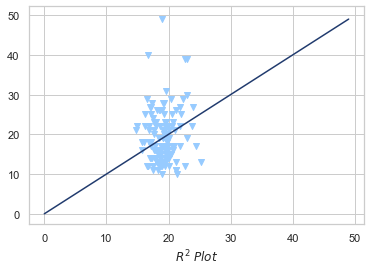

In [599]:
plt.figure()
plt.plot([0,49],[0,49])
plt.scatter(pred,true,color='#97CBFF',marker='v')
plt.xlabel('$R^2\;Plot$')

### pdata

In [17]:
X = pdata_maxabs
y = cog_norm
yamlfile = 'config/elastic_net_rf_pdata.yaml'
with open(yamlfile, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
write_keys = ['max_r2','best_alpha','num_features','params']
save_result_path = cfg.get("save_result_path")
# save_result_path = "./results/LassoCD_rf_cdata_nonorm.csv"
result, feature, score, metric = train_elastic_net(X,y,cfg)

In [ ]:
#record the rows in csv
with open(save_result_path,'w') as csv_file:
    # write header and rows to csv file
    csv_writer = csv.DictWriter(csv_file, write_keys)
    csv_writer.writeheader()
    csv_writer.writerows(result)

In [ ]:
from tkinter import _flatten
pred = list(_flatten(score[0]))
true = list(_flatten(score[1]))
df_score = pd.DataFrame({'Predict':pred,'True':true})
df_score.corr()

In [ ]:
plt.figure()
plt.plot([0,49],[0,49])
plt.scatter(pred,true,color='#97CBFF',marker='v')
plt.xlabel('$R^2\;Plot$')

## Single kernel RFE

In [11]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

In [12]:
def svmrfe(X, y, ll, ul, state, score_min, score_max, rf_params):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    score = []
    R2 = []
    MSE = []
    fmap = []
    pbar = tnrange((ul-ll)*10, desc='loop')
    ilist = range(ll,ul)
    for train_index, test_index in kf.split(X):
        mse = []
        r2 = []
        sco = []
        y_train, y_test_raw = y[train_index], y[test_index]
        X_train_tmp, X_test_tmp = X[train_index], X[test_index]
        y_test_raw = list(list(zip(*y_test_raw))[0])
        svr_rfe = SVR(kernel='linear')
        rfe = RFE(estimator=svr_rfe, n_features_to_select=1, step=1)
        rfe.fit(X_train_tmp, y_train)
        importance = np.argsort(rfe.ranking_)
        fmap.append(importance)       
        for i in ilist:
            X_train = X_train_tmp[:,importance[:i]]
            X_test = X_test_tmp[:,importance[:i]]
            rRF = RandomForestRegressor(n_estimators=rf_params[0], 
                                        criterion=rf_params[1], 
                                        max_depth = rf_params[2], 
                                        min_samples_leaf = rf_params[3], 
                                        min_samples_split = rf_params[4], 
                                        max_features=rf_params[5], 
                                        random_state=state)
            rRF.fit(X_train, np.ravel(y_train))
            y_test_pred_raw = rRF.predict(X_test)
            y_test_pred = cal_score(y_test_pred_raw,score_max,score_min)
            y_test = cal_score(y_test_raw,score_max,score_min)
            mse.append(mean_squared_error(y_test, y_test_pred))
            r2.append(r2_score(y_test, y_test_pred))
            sco.append((list(y_test_pred), list(y_test)))
            pbar.update(1)
        R2.append(r2)
        score.append(sco)
        MSE.append(mse)
    m_r2 = np.mean(np.array(R2), axis = 0)
    idx = np.argmax(m_r2)
    metric = (np.array(R2)[:,idx], np.array(MSE)[:,idx])
    feature_fd = [list(fmap[i][:ilist[idx]]) for i in range(10)]
    score_pred = [score[i][idx][0] for i in range(10)]
    score_true = [score[i][idx][1] for i in range(10)]
    score_fd = [score_pred, score_true]
    df = {'max_r2': m_r2[idx],'num_features': ilist[idx]}
    pbar.close()
#     plt.figure()
#     plt.plot(ilist,m_r2)
#     plt.xlabel('$alpha$')
#     plt.ylabel('$R^2$')
#     print('best r2_score=',m_r2[idx])
#     print('number of selected features:',ilist[idx])
    return df, feature_fd, score_fd, metric

In [13]:
def train_svmrfe(X, y, cfg):
    ## set configs    
    result = []
    ll = cfg.get("ll")
    ul = cfg.get("ul")
    step = cfg.get("step")
    state = cfg.get("random_state")
    score_min = cfg.get("score_min")
    score_max = cfg.get("score_max")
    rf_cv = cfg.get("rf_params_set")
    rf_params_list = to_sets(rf_cv)
    for rf_params in rf_params_list:
        result_row, feature, score, metric = svmrfe(X, y, ll, ul, state, score_min, score_max, rf_params)
        result_row.update({"params":rf_params})
        result.append(result_row)
        print(result_row)
    return result, feature, score, metric

### xdata

In [75]:
X = xdata_maxabs
y = cog_norm
yamlfile = 'config/svmrfe_rf_xdata.yaml'
with open(yamlfile, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [76]:
write_keys = ['max_r2','num_features','params']
save_result_path = cfg.get("save_result_path")
# save_result_path = "./results/LassoCD_rf_cdata_nonorm.csv"
result, feature, score, metric = train_svmrfe(X,y,cfg)


{'max_r2': -0.018576454720408274, 'num_features': 2, 'params': [50, 'mse', 2, 1, 2, 'sqrt']}



{'max_r2': -0.07620420050914276, 'num_features': 2, 'params': [50, 'mse', 2, 1, 2, 'auto']}



{'max_r2': -0.013018069872660765, 'num_features': 55, 'params': [50, 'mse', 2, 2, 2, 'sqrt']}



{'max_r2': -0.08335386835420072, 'num_features': 2, 'params': [50, 'mse', 2, 2, 2, 'auto']}



{'max_r2': 0.0009329611348650735, 'num_features': 52, 'params': [50, 'mse', 2, 3, 2, 'sqrt']}



{'max_r2': -0.03757910242133532, 'num_features': 44, 'params': [50, 'mse', 2, 3, 2, 'auto']}



{'max_r2': -0.03491780137158296, 'num_features': 61, 'params': [50, 'mse', 3, 1, 2, 'sqrt']}



{'max_r2': -0.1452583559860646, 'num_features': 23, 'params': [50, 'mse', 3, 1, 2, 'auto']}



{'max_r2': -0.01837473374416323, 'num_features': 61, 'params': [50, 'mse', 3, 2, 2, 'sqrt']}



{'max_r2': -0.11760130413991103, 'num_features': 44, 'params': [50, 'mse', 3, 2, 2, 'auto']}



{'max_r2': -0.0013239439303895707, 'num_features': 24, 'params': [50, 'mse', 3, 3, 2, 'sqrt']}



{'max_r2': -0.06515276770152742, 'num_features': 44, 'params': [50, 'mse', 3, 3, 2, 'auto']}



{'max_r2': -0.02602738072991225, 'num_features': 43, 'params': [50, 'mse', 5, 1, 2, 'sqrt']}



{'max_r2': -0.1436231012063763, 'num_features': 35, 'params': [50, 'mse', 5, 1, 2, 'auto']}



{'max_r2': -0.007956045502485798, 'num_features': 35, 'params': [50, 'mse', 5, 2, 2, 'sqrt']}



{'max_r2': -0.10998438366687327, 'num_features': 45, 'params': [50, 'mse', 5, 2, 2, 'auto']}



{'max_r2': 0.01599670298957586, 'num_features': 61, 'params': [50, 'mse', 5, 3, 2, 'sqrt']}



{'max_r2': -0.055982532742061365, 'num_features': 45, 'params': [50, 'mse', 5, 3, 2, 'auto']}



{'max_r2': -0.033333215091437406, 'num_features': 39, 'params': [50, 'mse', 15, 1, 2, 'sqrt']}



{'max_r2': -0.1639648387097373, 'num_features': 56, 'params': [50, 'mse', 15, 1, 2, 'auto']}



{'max_r2': -0.018881068302873817, 'num_features': 55, 'params': [50, 'mse', 15, 2, 2, 'sqrt']}



{'max_r2': -0.13219639997592983, 'num_features': 45, 'params': [50, 'mse', 15, 2, 2, 'auto']}



{'max_r2': -0.004198793046396332, 'num_features': 34, 'params': [50, 'mse', 15, 3, 2, 'sqrt']}



{'max_r2': -0.06324661193553187, 'num_features': 47, 'params': [50, 'mse', 15, 3, 2, 'auto']}



{'max_r2': -0.03286613835146991, 'num_features': 2, 'params': [100, 'mse', 2, 1, 2, 'sqrt']}



{'max_r2': -0.06371734204833047, 'num_features': 2, 'params': [100, 'mse', 2, 1, 2, 'auto']}



{'max_r2': -0.021194227640267183, 'num_features': 34, 'params': [100, 'mse', 2, 2, 2, 'sqrt']}



{'max_r2': -0.08059805522987995, 'num_features': 2, 'params': [100, 'mse', 2, 2, 2, 'auto']}



{'max_r2': -0.007906201733147133, 'num_features': 42, 'params': [100, 'mse', 2, 3, 2, 'sqrt']}



{'max_r2': -0.05408609069174173, 'num_features': 44, 'params': [100, 'mse', 2, 3, 2, 'auto']}



{'max_r2': -0.03190195860933233, 'num_features': 61, 'params': [100, 'mse', 3, 1, 2, 'sqrt']}



{'max_r2': -0.12515316284168942, 'num_features': 2, 'params': [100, 'mse', 3, 1, 2, 'auto']}



{'max_r2': -0.018432556311674075, 'num_features': 42, 'params': [100, 'mse', 3, 2, 2, 'sqrt']}



{'max_r2': -0.11133555450394159, 'num_features': 44, 'params': [100, 'mse', 3, 2, 2, 'auto']}



{'max_r2': 0.0007669427742230228, 'num_features': 55, 'params': [100, 'mse', 3, 3, 2, 'sqrt']}



{'max_r2': -0.07070549485237075, 'num_features': 44, 'params': [100, 'mse', 3, 3, 2, 'auto']}



{'max_r2': -0.017957667598579863, 'num_features': 31, 'params': [100, 'mse', 5, 1, 2, 'sqrt']}



{'max_r2': -0.1558871135392149, 'num_features': 45, 'params': [100, 'mse', 5, 1, 2, 'auto']}



{'max_r2': -0.014023041697461913, 'num_features': 40, 'params': [100, 'mse', 5, 2, 2, 'sqrt']}



{'max_r2': -0.10711136857311927, 'num_features': 45, 'params': [100, 'mse', 5, 2, 2, 'auto']}



{'max_r2': 0.01884061471663533, 'num_features': 63, 'params': [100, 'mse', 5, 3, 2, 'sqrt']}



{'max_r2': -0.07057806989276634, 'num_features': 43, 'params': [100, 'mse', 5, 3, 2, 'auto']}



{'max_r2': -0.01053468062339651, 'num_features': 64, 'params': [100, 'mse', 15, 1, 2, 'sqrt']}



{'max_r2': -0.16041882047480555, 'num_features': 47, 'params': [100, 'mse', 15, 1, 2, 'auto']}



{'max_r2': -0.00395443393090904, 'num_features': 40, 'params': [100, 'mse', 15, 2, 2, 'sqrt']}



{'max_r2': -0.11621338085391508, 'num_features': 45, 'params': [100, 'mse', 15, 2, 2, 'auto']}



{'max_r2': 0.005788739185714454, 'num_features': 45, 'params': [100, 'mse', 15, 3, 2, 'sqrt']}



{'max_r2': -0.07590574164590211, 'num_features': 47, 'params': [100, 'mse', 15, 3, 2, 'auto']}



{'max_r2': -0.03677313796356213, 'num_features': 3, 'params': [150, 'mse', 2, 1, 2, 'sqrt']}



{'max_r2': -0.07170473051133355, 'num_features': 2, 'params': [150, 'mse', 2, 1, 2, 'auto']}



{'max_r2': -0.023393911186097172, 'num_features': 42, 'params': [150, 'mse', 2, 2, 2, 'sqrt']}



{'max_r2': -0.08126001309096938, 'num_features': 2, 'params': [150, 'mse', 2, 2, 2, 'auto']}



{'max_r2': -0.0063726878574405735, 'num_features': 42, 'params': [150, 'mse', 2, 3, 2, 'sqrt']}



{'max_r2': -0.06633247752750875, 'num_features': 44, 'params': [150, 'mse', 2, 3, 2, 'auto']}



{'max_r2': -0.04174061891904636, 'num_features': 61, 'params': [150, 'mse', 3, 1, 2, 'sqrt']}



{'max_r2': -0.135177913481124, 'num_features': 2, 'params': [150, 'mse', 3, 1, 2, 'auto']}



{'max_r2': -0.018553639291808467, 'num_features': 61, 'params': [150, 'mse', 3, 2, 2, 'sqrt']}



{'max_r2': -0.11789239364260466, 'num_features': 44, 'params': [150, 'mse', 3, 2, 2, 'auto']}



{'max_r2': -0.0024241040225198573, 'num_features': 42, 'params': [150, 'mse', 3, 3, 2, 'sqrt']}



{'max_r2': -0.07622317899588088, 'num_features': 44, 'params': [150, 'mse', 3, 3, 2, 'auto']}



{'max_r2': -0.0279388122816416, 'num_features': 61, 'params': [150, 'mse', 5, 1, 2, 'sqrt']}



{'max_r2': -0.17200116956034384, 'num_features': 45, 'params': [150, 'mse', 5, 1, 2, 'auto']}



{'max_r2': -0.02444934113960522, 'num_features': 36, 'params': [150, 'mse', 5, 2, 2, 'sqrt']}



{'max_r2': -0.11256804361283564, 'num_features': 45, 'params': [150, 'mse', 5, 2, 2, 'auto']}



{'max_r2': 0.008105156559421112, 'num_features': 63, 'params': [150, 'mse', 5, 3, 2, 'sqrt']}



{'max_r2': -0.07249446005336443, 'num_features': 44, 'params': [150, 'mse', 5, 3, 2, 'auto']}



{'max_r2': -0.022552557719284883, 'num_features': 64, 'params': [150, 'mse', 15, 1, 2, 'sqrt']}



{'max_r2': -0.1778644858533705, 'num_features': 45, 'params': [150, 'mse', 15, 1, 2, 'auto']}



{'max_r2': -0.009114094050745813, 'num_features': 61, 'params': [150, 'mse', 15, 2, 2, 'sqrt']}



{'max_r2': -0.1212637714135973, 'num_features': 45, 'params': [150, 'mse', 15, 2, 2, 'auto']}



{'max_r2': 0.005574555018858151, 'num_features': 65, 'params': [150, 'mse', 15, 3, 2, 'sqrt']}



{'max_r2': -0.08075328192674848, 'num_features': 44, 'params': [150, 'mse', 15, 3, 2, 'auto']}



{'max_r2': -0.03369560234241302, 'num_features': 3, 'params': [200, 'mse', 2, 1, 2, 'sqrt']}



{'max_r2': -0.07342283134310006, 'num_features': 2, 'params': [200, 'mse', 2, 1, 2, 'auto']}



{'max_r2': -0.023091420571454125, 'num_features': 42, 'params': [200, 'mse', 2, 2, 2, 'sqrt']}



{'max_r2': -0.08427234599586944, 'num_features': 2, 'params': [200, 'mse', 2, 2, 2, 'auto']}



{'max_r2': -0.009059985691924066, 'num_features': 42, 'params': [200, 'mse', 2, 3, 2, 'sqrt']}



{'max_r2': -0.06001053613850808, 'num_features': 44, 'params': [200, 'mse', 2, 3, 2, 'auto']}



{'max_r2': -0.0393467682399441, 'num_features': 32, 'params': [200, 'mse', 3, 1, 2, 'sqrt']}



{'max_r2': -0.13347792643292325, 'num_features': 2, 'params': [200, 'mse', 3, 1, 2, 'auto']}



{'max_r2': -0.016762650935864896, 'num_features': 42, 'params': [200, 'mse', 3, 2, 2, 'sqrt']}



{'max_r2': -0.09917181388178117, 'num_features': 44, 'params': [200, 'mse', 3, 2, 2, 'auto']}



{'max_r2': 5.280614017946217e-05, 'num_features': 55, 'params': [200, 'mse', 3, 3, 2, 'sqrt']}



{'max_r2': -0.06804642969914845, 'num_features': 44, 'params': [200, 'mse', 3, 3, 2, 'auto']}



{'max_r2': -0.029047908056833115, 'num_features': 61, 'params': [200, 'mse', 5, 1, 2, 'sqrt']}



{'max_r2': -0.14896888284195892, 'num_features': 44, 'params': [200, 'mse', 5, 1, 2, 'auto']}



{'max_r2': -0.014512134695990154, 'num_features': 60, 'params': [200, 'mse', 5, 2, 2, 'sqrt']}



{'max_r2': -0.09210491988082024, 'num_features': 45, 'params': [200, 'mse', 5, 2, 2, 'auto']}



{'max_r2': 0.003144934978558078, 'num_features': 63, 'params': [200, 'mse', 5, 3, 2, 'sqrt']}



{'max_r2': -0.06569990773215391, 'num_features': 44, 'params': [200, 'mse', 5, 3, 2, 'auto']}



{'max_r2': -0.033251189200940834, 'num_features': 64, 'params': [200, 'mse', 15, 1, 2, 'sqrt']}



{'max_r2': -0.1506758835721252, 'num_features': 45, 'params': [200, 'mse', 15, 1, 2, 'auto']}



{'max_r2': -0.015555952974693466, 'num_features': 61, 'params': [200, 'mse', 15, 2, 2, 'sqrt']}



{'max_r2': -0.09909285502418214, 'num_features': 45, 'params': [200, 'mse', 15, 2, 2, 'auto']}



{'max_r2': 0.001432371607578442, 'num_features': 45, 'params': [200, 'mse', 15, 3, 2, 'sqrt']}



{'max_r2': -0.07359903591463582, 'num_features': 44, 'params': [200, 'mse', 15, 3, 2, 'auto']}


In [77]:
#record the rows in csv
with open(save_result_path,'w') as csv_file:
    # write header and rows to csv file
    csv_writer = csv.DictWriter(csv_file, write_keys)
    csv_writer.writeheader()
    csv_writer.writerows(result)

In [572]:
from tkinter import _flatten
pred = list(_flatten(score[0]))
true = list(_flatten(score[1]))
df_score = pd.DataFrame({'Predict':pred,'True':true})
df_score.corr()

,Predict,True
Predict,1.000000,0.109461
True,0.109461,1.000000


### rdata

In [18]:
X = rdata_maxabs
y = cog_norm
yamlfile = 'config/svmrfe_rf_rdata.yaml'
with open(yamlfile, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [19]:
write_keys = ['max_r2','num_features','params']
save_result_path = cfg.get("save_result_path")
result, feature, score, metric = train_svmrfe(X,y,cfg)


{'max_r2': 0.14260132850665064, 'num_features': 355, 'params': [50, 'mse', 15, 1, 2, 'sqrt']}


In [20]:
#record the rows in csv
with open(save_result_path,'w') as csv_file:
    # write header and rows to csv file
    csv_writer = csv.DictWriter(csv_file, write_keys)
    csv_writer.writeheader()
    csv_writer.writerows(result)

## Find the best result

In [190]:
csv_file = "results/LassoCD_rf_cdata_nonorm.csv"
df = pd.read_csv(csv_file)
df.loc[df['max_r2'].idxmax()]

max_r2                             -0.00601382
best_alpha                               5e-07
num_features                              1342
params          [150, 'mse', 15, 1, 2, 'sqrt']
Name: 30, dtype: object

In [14]:
csv_file = "results/LassoCD_rf_pdata.csv"
df = pd.read_csv(csv_file)
df.loc[df['max_r2'].idxmax()]

max_r2                              0.0419122
best_alpha                             0.0035
num_features                               43
params          [150, 'mse', 3, 1, 2, 'sqrt']
Name: 0, dtype: object

In [499]:
csv_file = "results/elastic_net_rf_cdata_nonorm.csv"
df = pd.read_csv(csv_file)
df.loc[df['max_r2'].idxmax()]

max_r2                            -0.00160481
best_alpha        (1e-06, 0.8200000000000001)
num_features                             1048
params          [100, 'mse', 3, 1, 2, 'sqrt']
Name: 0, dtype: object

In [78]:
csv_file = "results/svmrfe_rf_xdata.csv"
df = pd.read_csv(csv_file)
df.loc[df['max_r2'].idxmax()]

max_r2                              0.0188406
num_features                               63
params          [100, 'mse', 5, 3, 2, 'sqrt']
Name: 40, dtype: object

In [21]:
csv_file = "results/svmrfe_rf_rdata.csv"
df = pd.read_csv(csv_file)
df.loc[df['max_r2'].idxmax()]

max_r2                               0.142601
num_features                              355
params          [50, 'mse', 15, 1, 2, 'sqrt']
Name: 0, dtype: object

## multi kernel (on-going)

In [0]:
def single_lasso(x_train_tmp, y_train, ll, ul, step):
    fea_idx = []
    alpha = []
    ilist = np.linspace(ll,ul,step)
    for i in ilist:
        reg = Lasso(alpha=i)
        reg.fit(x_train_tmp, np.ravel(y_train))
        fea_idx.append([i for i,x in enumerate(reg.coef_) if x>0])
        alpha.append(i)
    return fea_idx, alpha

def single_elastic_net(x_train_tmp, y_train, ll1, ul1, step1, ll2, ul2, step2):
    fea_idx = []
    alpha = []
    inp = [list(create_alpha(ll1,ul1,step1)), list(np.linspace(ll2,ul2,step2))]
    g = [i for i in itertools.product(*inp)]
    for k in range(len(g)):
        reg = ElasticNet(random_state=state,alpha=g[k][0],l1_ratio=g[k][1])
        reg.fit(x_train_tmp, np.ravel(y_train))
        fea_idx.append([i for i,x in enumerate(reg.coef_) if x>0])
        alpha.append(g[k])
    return fea_idx, alpha

def single_rfe(x, y, ln, un):
    svr_rfe = SVR(kernel='linear')
    rfe = RFE(estimator=svr_rfe, n_features_to_select=1, step=1)
    rfe.fit(x, y)
    importance = np.argsort(rfe.ranking_)
    fea_idx = []
    alpha = []
    for i in range(ln,un):
        fea_idx.append(importance[:i])
        alpha.append(i)
    return fea_idx, alpha

def select_features(X, y_train, train_index, l):
    rf, ra = single_rfe(X[0][train_index], y_train, l[0][0], l[0][1])
    cf, ca = single_lasso(X[1][train_index], y_train, l[1][0], l[1][1], l[1][2])
    pf, pa = single_lasso(X[2][train_index], y_train, l[2][0], l[2][1], l[2][2])
    xf, xa = single_rfe(X[3][train_index], y_train, l[3][0],l[3][1])
    return ra, rf, ca, cf, pa, pf, xa, xf

def proximityMatrix(model, X, normalize=True):      

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat   

In [ ]:
def multi_RF(X, cfg, w):
    s= 0
    rf_cv = cfg.get("rf_params_set")
    rf_params_list = to_sets(rf_cv)
    for rf_params in rf_params_list:
    for i in range(4):
        X[i]=np.array(X[i]) 
        
        
        s += w[i]* rbf_kernel(X1[i], X2[i], params[i])
    return s

In [ ]:
def multi(X, y, L, params, state, score_min, score_max):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    multi_feature = []
    multi_score = []
    multi_r2 = []
    multi_mse = []
    w_grid = [list(np.linspace(0.0,1.0,11,dtype = np.float32))]
    W_grid = w_grid * len(L)
    W= [i for i in itertools.product(*W_grid) if np.sum(i)==1.0]
    W = [(0.2, 0.0, 0.1, 0.7)]
    pbar = tnrange(len(W), desc='loop')
    for t, w in enumerate(W):
        feature = []
        metric = []
        R2 = []
        MSE = []
        score = []
        for train_index, test_index in kf.split(y):
            y_test_raw = np.ravel(y[test_index])
            y_train = np.ravel(y[train_index])
            rRF = RandomForestRegressor(n_estimators=rf_params[0], 
                                        criterion=rf_params[1], 
                                        max_depth = rf_params[2], 
                                        min_samples_leaf = rf_params[3], 
                                        min_samples_split = rf_params[4], 
                                        max_features=rf_params[5], 
                                        random_state=state)
            ra, rf, ca, cf, pa, pf, xa, xf = select_features(X, y_train, train_index, L)
            mse = []
            r2 = []
            alpha = []
            fea = {}
            sco = {}
            for r in range(len(ra)):
                for c in range(len(ca)):
                    for p in range(len(pa)):
                        for x in range(len(xa)):
                            key = (ra[r],ca[c],pa[p],xa[x])
                            fea[key] = [list(rf[r]),cf[c],pf[p],list(xf[x])]
                            X_train = [X[0][train_index][:,rf[r]], 
                                       X[1][train_index][:,cf[c]], 
                                        X[2][train_index][:,pf[p]], 
                                       X[3][train_index][:,xf[x]]]
                            X_test = [X[0][test_index][:,rf[r]], 
                                      X[1][test_index][:,cf[c]], 
                                        X[2][test_index][:,pf[p]], 
                                      X[3][test_index][:,xf[x]]]
#                             kernel_train = gram_lin(X_train, X_train, w)
                            kernel_train = gram_rbf(X_train, X_train, params, w)

                            svr.fit(kernel_train, np.ravel(y_train))
                            y_test_pred_raw = svr.predict(gram_rbf(X_test, X_train, params, w))
                            y_test_pred = cal_score(y_test_pred_raw,score_max,score_min)
                            y_test = cal_score(y_test_raw,score_max,score_min)
                            mse.append(mean_squared_error(y_test, y_test_pred))
                            r2.append(r2_score(y_test, y_test_pred))
                            alpha.append(key)
                            sco[key] = (y_test_pred,y_test)
            R2.append(r2)
            MSE.append(mse)
            feature.append(fea)
            score.append(sco)
        avr_r2 = np.mean(np.array(R2),axis=0)
        avr_mse = np.mean(np.array(MSE),axis=0)
        idx = np.argmax(avr_r2)
        metric = (np.array(MSE)[:,idx], np.array(R2)[:,idx])
        multi_r2.append(avr_r2[idx])
        multi_mse.append(avr_mse[idx])
        pbar.update(1)
        print('No.', t+1,'. best r2_score=',avr_r2[idx],', corresponding alpha=', alpha[idx])
    pbar.close()
    multi_idx = np.argmax(multi_r2)
    print('End of grid search. best r2_score=',multi_r2[multi_idx])
    return feature, result, score, (alpha,avr_r2)              #not useful unless you control the weights

## Try different random states

In [198]:
X = cdata
y = cog_norm
yamlfile = 'config/lassoCD_rf_cdata.yaml'
with open(yamlfile, 'r') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [68]:
def find_params(cfg , result_csv):
    ## set configs    
    rf_cv = cfg.get("rf_params_set")
    rf_params_list = to_sets(rf_cv)
    idx = 0
    for rf_params in rf_params_list:
        df = pd.read_csv(result_csv)
        max_r2 = df["max_r2"].max()
        max_list = df[df["max_r2"]== max_r2].index.tolist()
        if idx in max_list:
            print(rf_params)
        idx+=1

In [199]:
def train_rnd(X, y, cfg):
    ## set configs    
    result = []
    ll = cfg.get("ll")
    ul = cfg.get("ul")
    step = cfg.get("step")
    weight = cfg.get("weight")
#     state = cfg.get("random_state")
    score_min = cfg.get("score_min")
    score_max = cfg.get("score_max")
    random_state = np.linspace(950,1000,50)
    rf_cv = cfg.get("rf_params_set")
    rf_params_list = to_sets(rf_cv)
    for rf_params in rf_params_list:
        for state in random_state:
            state = int(state)
            result_row=lassoCD(X, y, ll, ul, step, weight, state, score_min, score_max, rf_params)
            result_row.update({"state":state})
            print(result_row)
            result.append(result_row)
    return result

In [200]:
write_keys = ['max_r2','best_alpha','num_features','state']
save_result_path = "./results/LassoCD_rf_cdata_rnd.csv"
result = train_rnd(X,y,cfg)
#record the rows in csv
with open(save_result_path,'w') as csv_file:
    # write header and rows to csv file
    csv_writer = csv.DictWriter(csv_file, write_keys)
    csv_writer.writeheader()
    csv_writer.writerows(result)

[-0.38559759 -0.13205739 -0.20318853  0.07085804  0.17256182 -0.36083415
 -0.03447698 -0.02569699 -0.07501011 -0.09541366]

{'max_r2': -0.10886223513417537, 'best_alpha': 1e-05, 'num_features': 218, 'state': 950}


[-0.42251783 -0.09270371 -0.03340655 -0.18303711 -0.30476183 -0.06599234
  0.19141362  0.23549608  0.22442874 -0.01241138]

{'max_r2': -0.04901709269168716, 'best_alpha': 5e-07, 'num_features': 1360, 'state': 951}


[-0.10656084 -1.23519891 -0.15854487  0.20367452 -0.30324449  0.06928375
  0.13877713 -0.01246887 -0.37858897 -0.12866543]

{'max_r2': -0.1905537502822345, 'best_alpha': 5e-07, 'num_features': 1323, 'state': 952}


[-0.0983228  -0.09540043 -0.41067808  0.08008407 -1.61516233  0.0273001
  0.08178749  0.04266971 -0.30894976 -0.11790519]

{'max_r2': -0.24044257974303665, 'best_alpha': 1e-07, 'num_features': 3374, 'state': 953}


[ 0.04899935 -0.2980747  -0.00178825  0.02268527 -0.25711391 -0.00740613
  0.01986323  0.24085986 -0.21465744 -0.3817152 ]

{'max_r2': -0.08189979775670361, 'best_alpha': 5e-07, 'num_features': 1382, 'state': 954}


[-0.09050284 -0.10176753 -1.37171855 -0.20534094  0.10747683  0.01712687
 -0.04866829 -0.23114431  0.26669996  0.08411694]

{'max_r2': -0.1568979333912506, 'best_alpha': 1e-08, 'num_features': 3339, 'state': 955}


[ 0.01941597  0.4145445  -0.26733078 -0.07525176 -0.61468611  0.09059253
 -0.36483796 -0.1521092  -0.11576423 -0.23855909]

{'max_r2': -0.12933609813184627, 'best_alpha': 1e-07, 'num_features': 3364, 'state': 956}


[ 0.10181249  0.17087731 -0.08724135 -0.12264045 -0.17104084 -0.1598314
  0.13280633 -0.31754973 -1.67338821 -0.32731395]

{'max_r2': -0.24288882733874387, 'best_alpha': 1e-06, 'num_features': 941, 'state': 957}


[-0.68200798 -0.32101116 -0.19886706  0.27676494  0.04213388  0.04550392
 -0.03965281  0.17378843 -0.04987518 -0.08457517]

{'max_r2': -0.08802257068545666, 'best_alpha': 1e-06, 'num_features': 966, 'state': 958}


[-0.02829259  0.1222921  -0.07207086 -0.32816027 -0.35967482 -0.05846915
 -0.23677381 -0.14628018  0.04858917  0.11775143]

{'max_r2': -0.09364211676474352, 'best_alpha': 1e-06, 'num_features': 934, 'state': 959}


[ 2.02971133e-01 -4.04837413e-01 -6.77127740e-01 -2.27880783e-01
 -5.73838081e-04 -3.09257554e-01 -2.27645322e-01 -1.76072222e-01
 -6.56088301e-01 -3.59137839e-01]

{'max_r2': -0.2801143770903821, 'best_alpha': 4.9999999999999996e-06, 'num_features': 365, 'state': 960}


[-0.03823754  0.03007442 -0.17509256 -0.31033792  0.22561077  0.09970648
 -0.53058688 -0.50573545 -0.04937247 -0.05635822]

{'max_r2': -0.13037481416503638, 'best_alpha': 1e-06, 'num_features': 938, 'state': 961}


[ 0.00927777 -0.11355679  0.27071961  0.25444042 -0.27076541 -0.22449294
 -0.66233455  0.09837785 -0.30939894  0.19902979]

{'max_r2': -0.0742735247617678, 'best_alpha': 4.9999999999999996e-06, 'num_features': 329, 'state': 962}


[-0.15704344 -0.02479938 -0.11749626  0.37292792 -0.01049236 -0.0355259
 -0.08400127 -0.08563325 -1.13398291 -0.01628202]

{'max_r2': -0.12943012341864335, 'best_alpha': 4.9999999999999996e-06, 'num_features': 360, 'state': 963}


[-0.4895168  -0.68455361  0.16637687 -0.12515526 -0.02491    -0.40493492
  0.06843897 -0.13456292 -0.03644553  0.15261758]

{'max_r2': -0.15366351359344674, 'best_alpha': 1e-07, 'num_features': 3332, 'state': 964}


[-0.1630572  -0.18232346 -0.1133427  -0.254902    0.32894155  0.08273419
 -0.06942348  0.00614712 -0.07073332 -1.37491047]

{'max_r2': -0.18095910781379776, 'best_alpha': 1e-06, 'num_features': 966, 'state': 965}


[-0.10565411 -0.30446369  0.1431483  -0.01312245 -0.98775571  0.04409587
  0.14737153 -0.2091961   0.13401662 -0.06417429]

{'max_r2': -0.12146050163821548, 'best_alpha': 4.9999999999999996e-06, 'num_features': 373, 'state': 966}


[ 0.11270808 -0.55827377 -0.06078084  0.00498949 -0.05861116 -0.11146304
 -0.96638969  0.01020285 -0.13341831 -0.03856238]

{'max_r2': -0.17788421790485823, 'best_alpha': 5e-08, 'num_features': 3328, 'state': 967}


[-0.2506085  -0.05966938  0.05235006 -0.91220939 -0.16750801 -0.10200447
  0.27540555 -0.21439226  0.20713618 -0.18465307]

{'max_r2': -0.1364308824381241, 'best_alpha': 1e-05, 'num_features': 242, 'state': 968}


[-0.05767584  0.16682738 -1.45603405  0.27668585 -0.18708848 -0.08351961
  0.12081469 -0.1304603  -0.04996254 -0.05296941]

{'max_r2': -0.14471651167197477, 'best_alpha': 5e-07, 'num_features': 1323, 'state': 969}


[-1.69014179e-01 -1.51281254e-01  2.92169999e-03 -4.13616636e+00
  1.17548466e-01 -1.54814693e-01 -7.02033810e-02 -1.10511285e-01
 -2.64293982e-02 -1.04647751e-01]

{'max_r2': -0.47805239817264084, 'best_alpha': 1e-08, 'num_features': 3383, 'state': 970}


[-0.28968681 -0.29587218  0.04930922  0.0013416  -0.0180976  -0.02302399
 -0.1467398  -0.02731276  0.26307371 -0.1125706 ]

{'max_r2': -0.06158720581837639, 'best_alpha': 5e-07, 'num_features': 1427, 'state': 971}


[-3.36758037e-03  2.33539286e-03 -8.82399995e-01 -6.66148756e-02
 -6.24101187e-02 -1.41071126e-01 -3.85736099e-04 -1.72498688e-02
 -3.57292854e-02  1.56819528e-01]

{'max_r2': -0.10428651702789336, 'best_alpha': 4.9999999999999996e-06, 'num_features': 361, 'state': 972}


[-1.97075569e+00 -5.75181610e-02  2.13194499e-02 -3.58040796e-02
 -1.64543880e-02 -2.58052394e-02 -4.39091151e-02 -7.58637401e-01
  4.91623536e-02 -2.97679099e-04]

{'max_r2': -0.2958337235628614, 'best_alpha': 1e-06, 'num_features': 897, 'state': 973}


[ 0.04075888 -0.12360678 -0.0367059  -0.60378798 -0.28702561 -0.03347308
  0.10841075  0.15511614 -0.9949748  -0.33273749]

{'max_r2': -0.20901846390959222, 'best_alpha': 5e-07, 'num_features': 1369, 'state': 974}


[-0.08912012 -0.46039672  0.13411341 -0.96766962 -0.03270191  0.07755958
 -0.42882516 -0.27363496  0.09933433 -1.98012999]

{'max_r2': -0.3899979893308554, 'best_alpha': 5e-07, 'num_features': 1334, 'state': 975}


[-0.14247239 -0.30265014 -1.07928906  0.04443577 -0.14337878  0.26395356
 -0.04951003  0.02275433 -0.11796151  0.03352459]

{'max_r2': -0.14702683484415313, 'best_alpha': 4.9999999999999996e-06, 'num_features': 338, 'state': 976}


[-0.1736568  -0.21998995 -0.29932606 -0.60222326 -0.50847967  0.26256538
 -0.02132936  0.03229164  0.00354539  0.2426145 ]

{'max_r2': -0.12871979741757603, 'best_alpha': 1e-06, 'num_features': 953, 'state': 977}


[-0.32910167 -0.86906399 -0.10422997 -0.16925065 -0.04222182  0.01784907
  0.16079532  0.00277639  0.02298562  0.10654737]

{'max_r2': -0.12177235669872472, 'best_alpha': 5e-08, 'num_features': 3411, 'state': 978}


[-0.36331937  0.09033385 -1.46738357  0.0758375  -0.2867828  -0.00966391
 -0.56959791 -0.28009164  0.02041222 -0.04731501]

{'max_r2': -0.28432133455353703, 'best_alpha': 5e-07, 'num_features': 1329, 'state': 979}


[ 0.04331259 -0.22013169 -0.10525679  0.14400873 -0.11067265  0.11226104
 -0.27072755  0.18770907 -0.44170227  0.04840925]

{'max_r2': -0.06053724260110668, 'best_alpha': 1e-06, 'num_features': 928, 'state': 980}


[-4.08284079e-02 -1.59203906e-01 -2.27812895e-01 -1.57536875e-01
 -1.04280599e-01 -7.60390247e-01  8.15010830e-02  1.71986971e-04
 -3.79629175e-02  5.08602042e-02]

{'max_r2': -0.13487648539545607, 'best_alpha': 1e-07, 'num_features': 3358, 'state': 981}


[-0.16883265 -0.58189465  0.15733029  0.07482084 -0.01369876  0.022187
  0.19341693 -0.17881137 -1.34570637 -0.33538659]

{'max_r2': -0.2173112579891872, 'best_alpha': 1e-08, 'num_features': 3398, 'state': 982}


[-0.69825733 -0.10959347  0.15214063  0.12805239  0.06972496 -0.13091972
 -0.01781884 -0.07020669 -0.03889933  0.1652568 ]

{'max_r2': -0.05961379986899016, 'best_alpha': 4.9999999999999996e-06, 'num_features': 365, 'state': 983}


[-0.06484553 -0.09002817 -0.13488259 -0.16878536  0.13035138  0.28011119
 -0.10791948 -0.16735709  0.19436094 -0.01285762]

{'max_r2': -0.01454452674544653, 'best_alpha': 5e-07, 'num_features': 1399, 'state': 984}


[-0.29780537 -0.02947789 -0.02272505 -0.13050294 -0.05763263 -0.02448916
 -0.05254061 -0.60152813 -0.11067316 -0.09682077]

{'max_r2': -0.14352159783663, 'best_alpha': 1e-07, 'num_features': 3343, 'state': 985}


[-0.26524139  0.18607655 -0.80329637  0.07580688 -0.79456191  0.14180285
 -0.14528505 -0.43830945 -0.19489892  0.12841036]

{'max_r2': -0.21133469106137676, 'best_alpha': 5e-05, 'num_features': 97, 'state': 986}


[-0.1599152  -0.27432578  0.01645925  0.40199476  0.1786055  -0.21887478
 -0.09014333 -0.57909665 -0.24561579  0.10727489]

{'max_r2': -0.08688535595978643, 'best_alpha': 5e-08, 'num_features': 3357, 'state': 987}


[-0.06800946 -0.23280796 -0.61496463  0.09824081  0.11020694 -0.23571753
 -0.03188411 -0.15789645 -1.52603589 -0.12872039]

{'max_r2': -0.27726419058528945, 'best_alpha': 1e-06, 'num_features': 1018, 'state': 988}


[-0.16366169 -0.42849764 -0.30532791 -0.72015043 -0.19779811 -0.01659328
 -0.14626563  0.24310314  0.15106993 -0.05497239]

{'max_r2': -0.16390764456591952, 'best_alpha': 5e-07, 'num_features': 1344, 'state': 989}


[-0.63271789  0.01679411 -0.5998865   0.1522795  -0.29227316 -0.17837636
 -0.47335218 -0.49716026  0.15840216 -0.02310973]

{'max_r2': -0.23974696569016413, 'best_alpha': 5e-07, 'num_features': 1335, 'state': 990}


[-0.92665858  0.36759162 -0.58826638  0.09842393 -0.07154453  0.01447996
  0.19811446 -0.02026244  0.11719981 -0.20565422]

{'max_r2': -0.1075087076516038, 'best_alpha': 5e-07, 'num_features': 1359, 'state': 991}


[-0.20308963  0.08751256 -0.63206478  0.1326247  -0.28176791 -0.05325586
  0.06956477  0.04244461 -0.11906759 -0.04736734]

{'max_r2': -0.10117461164148701, 'best_alpha': 4.9999999999999996e-06, 'num_features': 373, 'state': 992}


[ 0.07507251  0.14932495 -0.09466935 -0.32525183  0.09495204  0.11173979
 -0.12266072 -1.75973117 -0.09448217 -0.43766408]

{'max_r2': -0.23810005608379703, 'best_alpha': 5e-07, 'num_features': 1345, 'state': 993}


[ 0.13582289 -0.31697436 -0.38271196  0.02261461 -0.05049182  0.16624562
  0.28203433 -0.14839333 -0.41496228  0.03061611]

{'max_r2': -0.06617716087001763, 'best_alpha': 1e-06, 'num_features': 993, 'state': 994}


[-0.45640052 -0.37026752 -0.09049011 -0.22325642  0.05061384 -0.09346945
 -0.40055617  0.11300305  0.14417413 -0.26715644]

{'max_r2': -0.1614870851988549, 'best_alpha': 5e-08, 'num_features': 3383, 'state': 995}


[ 0.09890569 -0.03873476  0.13334817  0.2594688  -0.44131062 -0.29221913
 -1.44739166 -0.4630918  -0.58750865 -0.18260464]

{'max_r2': -0.2933123021729881, 'best_alpha': 5e-08, 'num_features': 3356, 'state': 996}


[-0.51375392  0.1955561  -0.02928881  0.12862212 -0.06403125 -0.04886137
 -0.58775917 -1.45101811 -0.41871213  0.01430738]

{'max_r2': -0.27916952026085456, 'best_alpha': 5e-07, 'num_features': 1306, 'state': 997}


[-0.20340058  0.10297229 -0.26229902 -0.02696673 -0.04086154 -0.09308992
  0.05101861 -0.08505666 -0.1062958  -0.13955191]

{'max_r2': -0.08122580373347822, 'best_alpha': 4.9999999999999996e-06, 'num_features': 376, 'state': 998}


[-0.11951518  0.02971056  0.00511026 -0.31064106  0.11092849 -0.34787084
 -0.85697379  0.09956591  0.20268838 -0.22158   ]

{'max_r2': -0.14070636176799237, 'best_alpha': 1e-06, 'num_features': 956, 'state': 1000}


In [0]:
# param_test1 = {'n_estimators':range(100,101,1)}
# gsearch1 = GridSearchCV(estimator = RandomForestRegressor(random_state=5), 
#                        param_grid = param_test1, scoring='r2',cv=5)
# gsearch1.fit(X_train,y_train)

# means = gsearch1.cv_results_['mean_test_score']
# stds = gsearch1.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, gsearch1.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

# gsearch1.best_params_, gsearch1.best_score_